# Gradient Boosting Classifier

In [1]:
# Import
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import time

In [2]:
data = pl.read_parquet('../data/training_data.parquet')

X = data.drop("label").select([
    pl.col(col).cast(pl.Float32) for col in data.columns if col != "label"
]).to_numpy()

y = data["label"].to_numpy()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print(f"Features shape: {X.shape}, Labels shape: {y_encoded.shape}")

Features shape: (68250, 785), Labels shape: (68250,)


In [3]:
# Histogram-Based Gradient Boosting Classifier Pipeline

steps = [
    ('hgb', HistGradientBoostingClassifier(max_iter = 100, random_state = 42))
]

hgb_pipeline = Pipeline(steps)

inner_cv = KFold(n_splits = 4, random_state = 42, shuffle = True)

param_grid = {
    'hgb__learning_rate': [0.001, 0.01, 0.1],
    'hgb__max_depth': [3, 5, 7],
}

hgb_grid = GridSearchCV(
    estimator = hgb_pipeline,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = inner_cv,
    n_jobs = 6,
    verbose = 1
)

hgb_start = time.time()
hgb_grid.fit(X, y_encoded)
hgb_end = time.time()
hgb_diff = hgb_end - hgb_start
print("Gradient Boosting Training Complete")
print(f"Time to train Gradient Boosting Model: {np.round(hgb_diff, 2)} seconds")

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Gradient Boosting Training Complete
Time to train Gradient Boosting Model: 440.9 seconds


In [4]:
best_params = hgb_grid.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'hgb__learning_rate': 0.1, 'hgb__max_depth': 7}


In [5]:
best_score = hgb_grid.best_score_
print(f"Best cross-validation accuracy: {best_score:.4f}")

Best cross-validation accuracy: 0.9542


In [6]:
best_estimator = hgb_grid.best_estimator_
y_pred = best_estimator.predict(X)

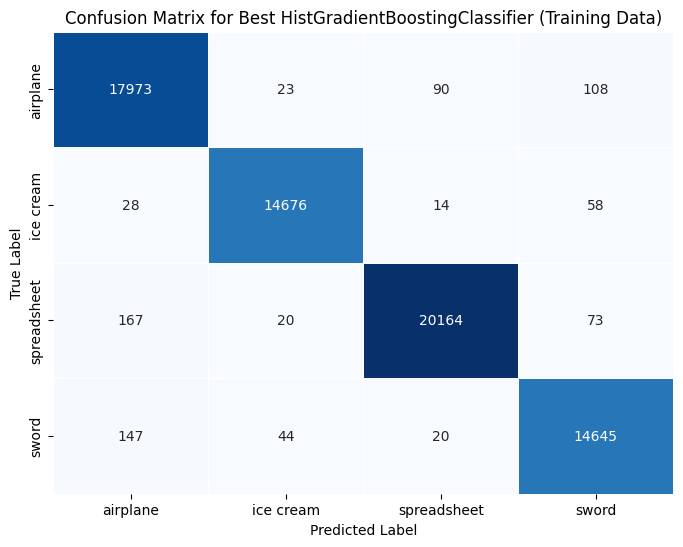

In [7]:
cm = confusion_matrix(y_encoded, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=.5,
    cbar=False,
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.title('Confusion Matrix for Best HistGradientBoostingClassifier (Training Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()